In [ ]:
import time

def print_elapsed_time(start_time, end_time):
    elapsed = end_time - start_time
    seconds = int(elapsed % 60)
    minutes = int((elapsed // 60) % 60)
    hours = int(elapsed // 3600)
    print(f"⏱️ Elapsed time: {hours}h {minutes}m {seconds}s ({elapsed:.2f} seconds)")

# Usage example
start_time = time.time()

In [17]:
# ================================
# SUPPRESS_WARNINGS
# Unified Warning & Log Suppression Flag
# ================================
SUPPRESS_ALL_WARNINGS = True  # Set to False to enable logs and warnings

if SUPPRESS_ALL_WARNINGS:
    import os
    import sys
    import warnings
    from absl import logging as absl_logging

    # Suppress TensorFlow logs (INFO, WARNING, ERROR)
    os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # 0=all, 1=INFO, 2=WARNING, 3=ERROR

    # Optional: avoid cuDNN math optimizations that log on CPU
    os.environ["XLA_FLAGS"] = "--xla_cpu_enable_fast_math=false"

    # Suppress absl logging (used by TF and JAX)
    absl_logging.set_verbosity(absl_logging.ERROR)

    # Suppress Python warnings
    warnings.filterwarnings("ignore")

    # Suppress stderr output (including CUDA/cuDNN plugin registration)
    class NullIO:
        def write(self, x): pass
        def flush(self): pass
    sys.stderr = NullIO()

else:
    # Enable default Python warnings and reset logging
    import warnings
    from absl import logging as absl_logging

    warnings.filterwarnings("default")
    absl_logging.set_verbosity(absl_logging.INFO)
    import sys
    sys.stderr = sys.__stderr__  # Restore default stderr


In [ ]:
# Dowmload Bert and Massive Dataset
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from datasets import load_dataset
import os

# Set up cache directories
#model_cache = os.environ.get("HF_TRANSFORMERS_CACHE", "/kaggle/working/hf_models_cache")
#dataset_cache = os.environ.get("HF_DATASETS_CACHE", "/kaggle/working/hf_datasets_cache")
model_cache = os.environ.get("HF_TRANSFORMERS_CACHE", "./hf_models_cache")
dataset_cache = os.environ.get("HF_DATASETS_CACHE", "./hf_datasets_cache")

os.makedirs(model_cache, exist_ok=True)
os.makedirs(dataset_cache, exist_ok=True)

# Select device: GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# Number of intent classes
num_classes = 60

# Load tokenizer and model with cache
tokenizer = BertTokenizer.from_pretrained(
    "bert-base-multilingual-cased",
    cache_dir=model_cache
)

model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased",
    cache_dir=model_cache,
    num_labels=num_classes
)

# Move model to GPU if available
model.to(device)

# Load MASSIVE dataset
dataset = load_dataset(
    "AmazonScience/massive",
    "all_1.1",
    cache_dir=dataset_cache,
    trust_remote_code=True
)

print("✅ Tokenizer, model, and dataset downloaded successfully!")

print(dataset.keys())  # will list ['train', 'test', 'validation'] if available

✅ Using device: cpu
✅ Tokenizer, model, and dataset downloaded successfully!
dict_keys(['train', 'validation', 'test'])


In [19]:
#Print number of expected steps

import math

# Define batch size
BATCH_SIZE = 32

# Calculate steps for each dataset split
for split in dataset.keys():
    total_samples = len(dataset[split])
    steps = math.ceil(total_samples / BATCH_SIZE)
    print(f"➡️ Split: '{split}' | Total samples: {total_samples} | Batch size: {BATCH_SIZE} | Steps per epoch: {steps}")


➡️ Split: 'train' | Total samples: 598728 | Batch size: 32 | Steps per epoch: 18711
➡️ Split: 'validation' | Total samples: 105716 | Batch size: 32 | Steps per epoch: 3304
➡️ Split: 'test' | Total samples: 154648 | Batch size: 32 | Steps per epoch: 4833


In [20]:
# tokenizer
from transformers import BertTokenizer
from datasets import load_from_disk
import torch
import os

# Select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# Define tokenizer (from cache if available)
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", cache_dir="./hf_models_cache")

# Text and label column names
text_col = "utt"
label_col = "intent"

# Path to save/load tokenized dataset
tokenized_cache_path = "./massive_tokenized"

# Check if tokenized dataset already exists
if os.path.exists(tokenized_cache_path):
    print("🔁 Loading cached tokenized dataset...")
    tokenized_dataset = load_from_disk(tokenized_cache_path)
else:
    print("🚀 Tokenizing dataset from scratch...")
    
    # Tokenization function
    def tokenize(example):
        return tokenizer(example[text_col], truncation=True, padding="max_length")

    # Apply tokenization to each split
    tokenized_dataset = dataset.map(tokenize, batched=True)

    # Rename label column
    tokenized_dataset = tokenized_dataset.rename_column(label_col, "labels")

    # Save tokenized dataset
    tokenized_dataset.save_to_disk(tokenized_cache_path)
    print("✅ Tokenized dataset saved.")

# Set dataset format for PyTorch
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Optional: move one sample to device to test
sample = {k: v.to(device) for k, v in tokenized_dataset["train"][0].items()}
print(f"✅ Sample batch on {device}")
# print(sample)


✅ Using device: cpu
🔁 Loading cached tokenized dataset...
✅ Sample batch on cpu


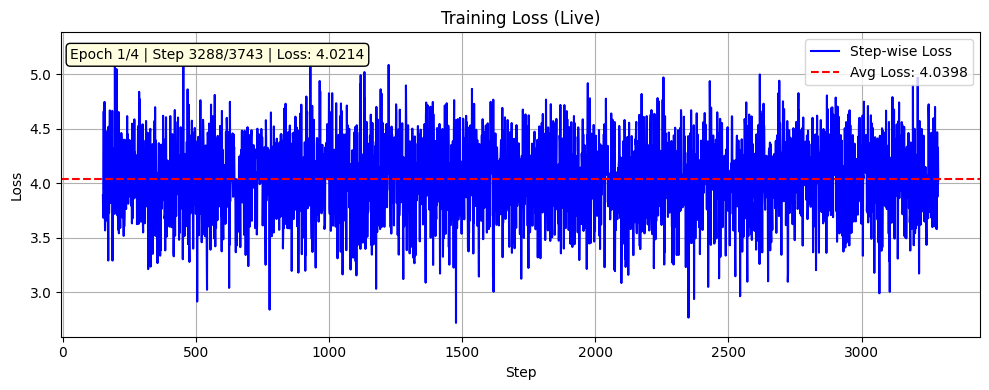

In [ ]:
# Training Loop 

import os
import torch
import json
import shutil
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
from transformers import BertForSequenceClassification, DataCollatorWithPadding, BertTokenizer
from torch.utils.data import DataLoader
from torch.optim import AdamW

# ===== Config =====
DATA_PERCENT = 0.20
BATCH_SIZE = 32
EPOCHS = 4  # ✅ Number of epochs
CHECKPOINT_EVERY = 50
MODEL_NAME = "bert-base-multilingual-cased"
CACHE_DIR = "./hf_models_cache"
SAVE_DIR = "./checkpoints"
FINAL_SAVE_PATH = "./mbert_massive_finetuned"

# ===== Device =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")

# ===== Load tokenizer and dataset (assumes `tokenized_dataset` is already in memory) =====
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME, cache_dir=CACHE_DIR)

# Scale dataset splits by DATA_PERCENT
train_size = int(len(tokenized_dataset["train"]) * DATA_PERCENT)
val_size   = int(len(tokenized_dataset["validation"]) * DATA_PERCENT)
test_size  = int(len(tokenized_dataset["test"]) * DATA_PERCENT)


train_dataset = tokenized_dataset["train"].select(range(train_size))
val_dataset = tokenized_dataset["validation"].select(range(val_size))
test_dataset = tokenized_dataset["test"].select(range(test_size))

collator = DataCollatorWithPadding(tokenizer=tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collator)

# ===== Initialize model and optimizer =====
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=60, cache_dir=CACHE_DIR)
optimizer = AdamW(model.parameters(), lr=5e-5)
model.to(device)

# ===== Resume from checkpoint if available =====
def get_latest_checkpoint():
    if not os.path.exists(SAVE_DIR):
        return None
    checkpoints = [f for f in os.listdir(SAVE_DIR) if f.startswith("checkpoint_epoch")]
    if not checkpoints:
        return None
    checkpoints.sort(key=lambda x: os.path.getmtime(os.path.join(SAVE_DIR, x)))
    return os.path.join(SAVE_DIR, checkpoints[-1])

start_epoch = 0
start_step = 0
prev_ckpt_path = None
latest_ckpt = get_latest_checkpoint()

if latest_ckpt:
    print(f"[INFO] Resuming from checkpoint: {latest_ckpt}")
    model = BertForSequenceClassification.from_pretrained(latest_ckpt).to(device)
    tokenizer = BertTokenizer.from_pretrained(latest_ckpt)
    optimizer.load_state_dict(torch.load(os.path.join(latest_ckpt, "optimizer.pt")))
    with open(os.path.join(latest_ckpt, "training_state.json")) as f:
        state = json.load(f)
        start_epoch = state["epoch"]
        start_step = state["step"]
    prev_ckpt_path = latest_ckpt
    print(f"[INFO] Resuming from epoch {start_epoch+1}, step {start_step+1}")
else:
    print("[INFO] No checkpoint found. Starting fresh.")

# ===== Tracking loss =====
losses = []
steps = []
global_step = start_epoch * len(train_dataloader) + start_step

# ===== Training loop =====
for epoch in range(start_epoch, EPOCHS):
    print(f"\n[INFO] Starting epoch {epoch+1}...")
    model.train()
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        if epoch == start_epoch and step < start_step:
            print(f"  [INFO] Skipping step {step+1} (already trained)")
            continue

        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        global_step += 1
        steps.append(global_step)
        losses.append(loss.item())
        
        # 🔄 Save to CSV after each step
        pd.DataFrame({'step': steps, 'loss': losses}).to_csv("training_log.csv", index=False)

        
        #if (step + 1) % 1 == 0:
            #print(f"  [Epoch {epoch+1} | Step {step+1}] Loss: {loss.item():.4f}")
            #print(f"✅ Running epoch {epoch+1} of {EPOCHS} | Step {step+1} of {len(train_dataloader)} | 🔻 Loss: {loss.item():.4f}")

                # Plot step-wise loss
        clear_output(wait=True)
        plt.figure(figsize=(10, 4))
        plt.plot(steps, losses, label='Step-wise Loss', color='blue')
        
        # Plot average loss line
        if len(steps) > 1:
            avg_so_far = sum(losses) / len(losses)
            plt.axhline(avg_so_far, color='red', linestyle='--', label=f'Avg Loss: {avg_so_far:.4f}')
        
        # Add status text on the graph
        status_text = f"Epoch {epoch+1}/{EPOCHS} | Step {step+1}/{len(train_dataloader)} | Loss: {loss.item():.4f}"
        plt.text(0.01, 0.95, status_text, transform=plt.gca().transAxes,
                 fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', facecolor='lightyellow'))
        
        # Final touches
        plt.xlabel("Step")
        plt.ylabel("Loss")
        plt.title("Training Loss (Live)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

        # ===== Save checkpoint =====
        if (step + 1) % CHECKPOINT_EVERY == 0:
            ckpt_dir = os.path.join(SAVE_DIR, f"checkpoint_epoch{epoch}_step{step+1}")
            os.makedirs(ckpt_dir, exist_ok=True)
            model.save_pretrained(ckpt_dir)
            tokenizer.save_pretrained(ckpt_dir)
            torch.save(optimizer.state_dict(), os.path.join(ckpt_dir, "optimizer.pt"))
            with open(os.path.join(ckpt_dir, "training_state.json"), "w") as f:
                json.dump({"epoch": epoch, "step": step + 1}, f)

            # Clean previous checkpoint
            if prev_ckpt_path and os.path.exists(prev_ckpt_path):
                shutil.rmtree(prev_ckpt_path)
            prev_ckpt_path = ckpt_dir
            print(f"[INFO] Checkpoint saved at step {step+1} of epoch {epoch+1}")

    avg_loss = total_loss / len(train_dataloader)
    print(f"[INFO] Epoch {epoch+1} completed. Avg Loss: {avg_loss:.4f}")
    start_step = 0  # Reset for next epoch

# ===== Final Save =====
os.makedirs(FINAL_SAVE_PATH, exist_ok=True)
model.save_pretrained(FINAL_SAVE_PATH)
tokenizer.save_pretrained(FINAL_SAVE_PATH)
print("[✅] Final model saved at:", FINAL_SAVE_PATH)

# ===== Save final loss curve =====
#plt.figure(figsize=(10, 4))
#plt.plot(steps, losses, label='Training Loss')
#plt.xlabel("Steps")
#plt.ylabel("Loss")
#plt.title("Final Training Loss Curve")
#plt.legend()
#plt.grid(True)
#plt.savefig(os.path.join(FINAL_SAVE_PATH, "training_loss_plot.png"))
#plt.show()



In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.utils.data import DataLoader

# Create validation and test dataloaders
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collator)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collator)

def evaluate(model, dataloader, split_name="Validation"):
    model.eval()
    preds, labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            output = model(**batch)
            logits = output.logits
            preds.extend(torch.argmax(logits, dim=-1).cpu().numpy())
            labels.extend(batch['labels'].cpu().numpy())

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')

    print(f"\n📊 {split_name} Set Metrics:")
    print(f"   Accuracy : {acc:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall   : {recall:.4f}")
    print(f"   F1 Score : {f1:.4f}")

# ===== Run evaluation =====
evaluate(model, val_dataloader, "Validation")
evaluate(model, test_dataloader, "Test")



📊 Validation Set Metrics:
   Accuracy : 0.7294
   Precision: 0.6885
   Recall   : 0.7294
   F1 Score : 0.6946

📊 Test Set Metrics:
   Accuracy : 0.7038
   Precision: 0.6750
   Recall   : 0.7038
   F1 Score : 0.6649


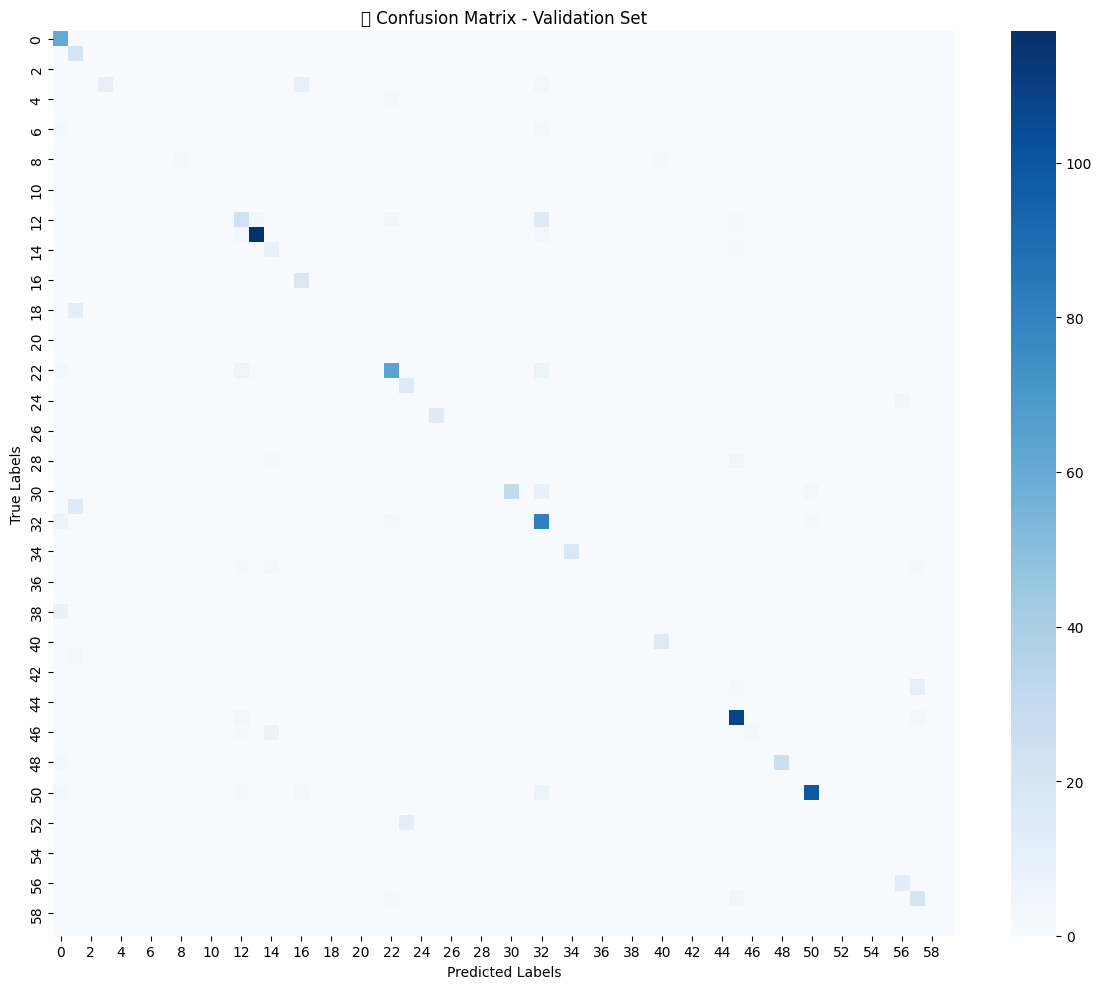

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, dataloader, class_names, split_name="Validation"):
    model.eval()
    preds, labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            output = model(**batch)
            logits = output.logits
            preds.extend(torch.argmax(logits, dim=-1).cpu().numpy())
            labels.extend(batch['labels'].cpu().numpy())

    cm = confusion_matrix(labels, preds, labels=range(len(class_names)))
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
    plt.title(f"📊 Confusion Matrix - {split_name} Set")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.tight_layout()
    plt.show()

# 🔁 Get class names from dataset
class_names = tokenized_dataset["train"].features["labels"].names


# 📊 Plot
plot_confusion_matrix(model, val_dataloader, class_names, split_name="Validation")


In [ ]:
def predict_intent(text, model, tokenizer, class_names):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=-1)
        predicted_class = torch.argmax(probs, dim=1).item()
        confidence = probs[0, predicted_class].item()
    return class_names[predicted_class], confidence


# ✅ Restructure: Nested dict with clear categories
sentences = {
    "greeting": {
        "English": "How are you?",
        "Spanish": "¿Cómo estás?",
        "French": "Comment ça va?",
        "Hindi": "आप कैसे हैं?"
    },
    "weather_query": {
        "English": "What's the weather like today?",
        "Spanish": "¿Cómo está el clima hoy?",
        "French": "Quel temps fait-il aujourd'hui?",
        "Hindi": "आज मौसम कैसा है?"
    },
    "alarm_set": {
        "English": "Set an alarm for 7 AM.",
        "Spanish": "Configura una alarma para las 7 AM.",
        "French": "Mets une alarme à 7 heures.",
        "Hindi": "सुबह 7 बजे के लिए अलार्म सेट करें।"
    }
}

# 🔍 Predict and print results
for intent_type, lang_dict in sentences.items():
    print(f"\n=== 🌍 {intent_type.upper()} ===")
    for lang, sentence in lang_dict.items():
        intent, confidence = predict_intent(sentence, model, tokenizer, class_names)
        print(f"[{lang}] → \"{sentence}\"")
        print(f"  ↪ Predicted Intent: {intent} (Confidence: {confidence:.2f})")



=== 🌍 GREETING ===
[English] → "How are you?"
  ↪ Predicted Intent: general_quirky (Confidence: 0.35)
[Spanish] → "¿Cómo estás?"
  ↪ Predicted Intent: general_quirky (Confidence: 0.32)
[French] → "Comment ça va?"
  ↪ Predicted Intent: general_quirky (Confidence: 0.31)
[Hindi] → "आप कैसे हैं?"
  ↪ Predicted Intent: calendar_query (Confidence: 0.35)

=== 🌍 WEATHER_QUERY ===
[English] → "What's the weather like today?"
  ↪ Predicted Intent: weather_query (Confidence: 0.57)
[Spanish] → "¿Cómo está el clima hoy?"
  ↪ Predicted Intent: weather_query (Confidence: 0.52)
[French] → "Quel temps fait-il aujourd'hui?"
  ↪ Predicted Intent: general_quirky (Confidence: 0.27)
[Hindi] → "आज मौसम कैसा है?"
  ↪ Predicted Intent: weather_query (Confidence: 0.75)

=== 🌍 ALARM_SET ===
[English] → "Set an alarm for 7 AM."
  ↪ Predicted Intent: general_quirky (Confidence: 0.17)
[Spanish] → "Configura una alarma para las 7 AM."
  ↪ Predicted Intent: general_quirky (Confidence: 0.15)
[French] → "Mets une alar

In [ ]:
import shutil

# This will create: /kaggle/working/mbert_massive_finetuned.zip
shutil.make_archive(
    "./mbert_massive_finetuned",  # Output zip file path (without .zip extension)
    'zip',
    "./mbert_massive_finetuned"   # Folder to zip
)

'/kaggle/working/mbert_massive_finetuned.zip'

In [ ]:
end_time = time.time()
print_elapsed_time(start_time, end_time)


⏱️ Elapsed time: 0h 7m 9s (429.22 seconds)
